# Environment

In [6]:
# Import required libraries
import loompy
import numpy as np
import pandas as pd
import gc  # for garbage collection
import os
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

# Set working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3_dev/Mousebrain')

# Add local_functions directory to Python path
from local_functions import *

# Set plotting style
plt.style.use('default')  # Use default matplotlib style
sns.set_theme()  # Apply seaborn styling
sns.set_palette("husl")

In [7]:
loom_path = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3_dev/Mousebrain/DATA/dev_all.loom"

In [8]:
# Verify file exists
print(f"File exists: {os.path.exists(loom_path)}")
print(f"File size: {os.path.getsize(loom_path) / (1024**3):.2f} GB")

File exists: True
File size: 9.56 GB


In [9]:
# Create plots directory if it doesn't exist
os.makedirs('plots_sc', exist_ok=True)

# Define functions

**Column attributes**
- Age: object
- BTSNE: float64
- CellCycle: float64
- CellID: object
- Cell_Conc: int64
- Chemistry: object
- ChipID: object
- Class: object
- ClusterName: object
- Clusters: int64
- Date_Captured: object
- DonorID: object
- DoubletFinderPCA: float64
- HPF: float64
- HPF_LogPP: float64
- HPF_theta: float64
- IsCycling: uint8
- Label: object
- Location_E9_E11: object
- NCellsCluster: int64
- NGenes: float64
- Num_Pooled_Animals: int64
- PCA: float64
- PCR_Cycles: int64
- Plug_Date: object
- Project: object
- PseudoAge: float64
- PseudoTissue: object
- Region: object
- SampleID: object
- SampleName: object
- Sample_Index: object
- Sex: object
- Species: object
- Split: int64
- Strain: object
- Subclass: object
- TSNE: float64
- Target_Num_Cells: float64
- Tissue: object
- TotalUMI: float64
- Transcriptome: object
- UMAP: float32
- UMAP3D: float32
- cDNA_Lib_Ok: object
- ngperul_cDNA: object

# Data exploration

In [10]:
examine_loom_file(loom_path)


Dataset shape: (31053, 292495)
Number of cells: 292,495
Number of genes: 31,053

Column attributes (cell metadata):
- Age: object
- BTSNE: float64
- CellCycle: float64
- CellID: object
- Cell_Conc: int64
- Chemistry: object
- ChipID: object
- Class: object
- ClusterName: object
- Clusters: int64
- Date_Captured: object
- DonorID: object
- DoubletFinderPCA: float64
- HPF: float64
- HPF_LogPP: float64
- HPF_theta: float64
- IsCycling: uint8
- Label: object
- Location_E9_E11: object
- NCellsCluster: int64
- NGenes: float64
- Num_Pooled_Animals: int64
- PCA: float64
- PCR_Cycles: int64
- Plug_Date: object
- Project: object
- PseudoAge: float64
- PseudoTissue: object
- Region: object
- SampleID: object
- SampleName: object
- Sample_Index: object
- Sex: object
- Species: object
- Split: int64
- Strain: object
- Subclass: object
- TSNE: float64
- Target_Num_Cells: float64
- Tissue: object
- TotalUMI: float64
- Transcriptome: object
- UMAP: float32
- UMAP3D: float32
- cDNA_Lib_Ok: object
- ng

In [11]:
data = get_data(loom_path, 'Srrm4')

In [12]:
data_df = pd.DataFrame(data)

In [13]:
def create_pseudo_cells(df, group_by_column):
    """
    Create pseudo-cells by aggregating data grouped by a specific column.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing single-cell data
    group_by_column : str
        Column name to group the cells by
        
    Returns:
    --------
    pandas.DataFrame
        Aggregated pseudo-cell data with mean/median values for numeric columns
    """
    # Numeric columns to aggregate
    numeric_cols = ['PseudoAge', 'Expression', 'TotalUMI', 'NGenes']
    
    # Initialize aggregation dictionary with numeric columns
    agg_dict = {
        'PseudoAge': 'mean',  # Average pseudo age
        'Expression': 'mean',  # Average expression
        'TotalUMI': 'mean',  # Average UMI count
        'NGenes': 'mean',  # Average number of genes
        'CellID': 'count'  # Count of cells in each group
    }
    
    # Add categorical columns to aggregation dict, excluding the grouping column
    categorical_cols = ['Tissue', 'Sex', 'Subclass', 'Region', 'Age', 'Class']
    for col in categorical_cols:
        if col in df.columns and col != group_by_column:
            agg_dict[col] = lambda x: x.mode().iloc[0]
    
    # Group by the specified column and aggregate
    pseudo_cells = df.groupby(group_by_column).agg(agg_dict).reset_index()
    
    # Rename the CellID column to CellCount
    pseudo_cells = pseudo_cells.rename(columns={'CellID': 'CellCount'})
    
    # Round numeric columns to 2 decimal places
    for col in numeric_cols:
        if col in pseudo_cells.columns:
            pseudo_cells[col] = pseudo_cells[col].round(2)
            
    return pseudo_cells

In [14]:
data_df.head()

,Age,Tissue,Sex,Subclass,Class,Region,PseudoAge,Expression,CellID,ClusterName,TotalUMI,NGenes
0,e7.0,All (No extraembryonal),?,Parietal endoderm,Gastrulation,Head,7.050,0.0,10X39_2_A_1:AAACTTGAGAGCAGx,ParEndo,2189.0,1032.0
1,e7.0,All (No extraembryonal),?,Parietal endoderm,Gastrulation,Head,9.220,0.0,10X39_3_A_1:AAGTTCCTAGCCTAx,ParEndo,2757.0,1436.0
2,e7.0,All (No extraembryonal),?,Parietal endoderm,Gastrulation,Head,9.265,0.0,10X39_2_A_1:GGGACCACAGCGTTx,ParEndo,4941.0,1831.0
3,e7.0,All (No extraembryonal),?,Parietal endoderm,Gastrulation,Head,9.545,0.0,10X39_2_A_1:CAGCAATGGGTAGGx,ParEndo,8176.0,2559.0
4,e7.0,All (No extraembryonal),?,Parietal endoderm,Gastrulation,Head,8.685,1.0,10X39_3_A_1:CAGCCTACAGAGATx,ParEndo,16640.0,4084.0


In [15]:
# Print unique values for each column
print("Age:", list(data_df.Age.unique()))
print("Tissue:", list(data_df.Tissue.unique()))
print("Sex:", list(data_df.Sex.unique()))
print("Subclass:", list(data_df.Subclass.unique()))
print("Class:", list(data_df.Class.unique()))
print("Region:", list(data_df.Region.unique()))
print("PseudoAge:", list(data_df.PseudoAge.unique()))
print("ClusterName:", list(data_df.ClusterName.unique()))

Age: ['e7.0', 'e8.0', 'e8.5', 'e11.0', 'e9.0', 'e10.0', 'e18.0', 'e13.5', 'e12.5', 'e12.0', 'e14.5', 'e17.0', 'e15.0', 'e14.0', 'e16.0', 'e16.5', 'e15.5', 'e13.0', 'e17.5', 'e16.25']
Tissue: ['All (No extraembryonal)', 'Head', 'Hindbrain', 'Forebrain', 'Midbrain', 'ForebrainDorsal', 'ForebrainVentroLateral', 'ForebrainVentral', 'ForebrainVentroThalamic', 'MidbrainVentral', 'MidbrainDorsal']
Sex: ['?']
Subclass: ['Parietal endoderm', 'Undefined', 'Extraembryonic ectoderm', 'Endoderm', 'Visceral endoderm', 'Extraembryonic endoderm', 'Cardiac mesoderm', 'Osteochondral mesoderm', 'Mesoderm', 'Hematoendothelial lineage', 'Mesenchyme', 'Nascent mesoderm', 'Primordial germ cells', 'Epiblast', 'Definitive endoderm', 'Anterior primitive streak', 'Node', 'Early choroid plexus', 'Fourth-ventricle roof plate', 'Floor plate', 'Caudal', 'Anterior', 'Optic cup', 'Neuromesodermal progenitors', 'Cardiac', 'Paraxial', 'Pharyngeal', 'Neural crest', 'Gut', 'Early ectoderm', 'Dorsal early ectoderm', 'Surfa

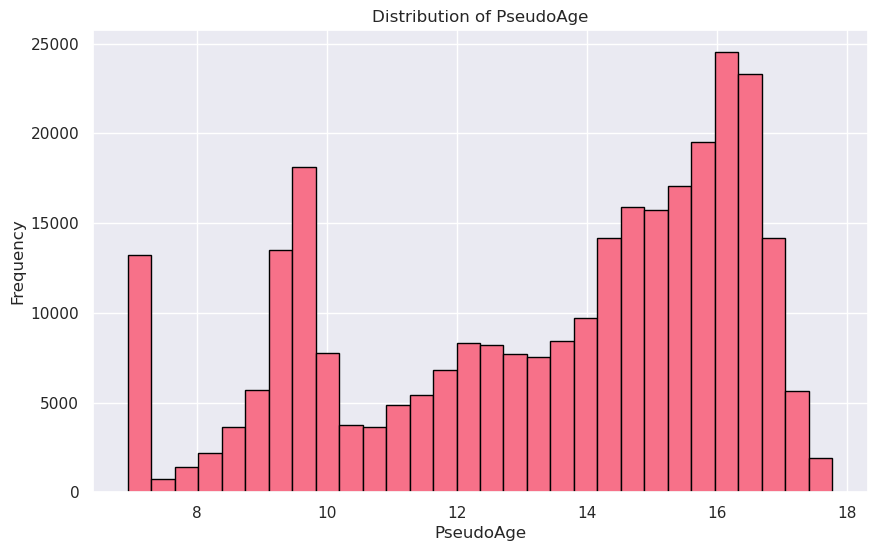

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(data_df.PseudoAge, bins=30, edgecolor='black')
plt.xlabel('PseudoAge')
plt.ylabel('Frequency')
plt.title('Distribution of PseudoAge')
plt.show()

In [17]:
# Create 10 bins for PseudoAge
min_age = data_df.PseudoAge.min()
max_age = data_df.PseudoAge.max()
bin_size = (max_age - min_age) / 10

# Create bins
bins = [min_age + i * bin_size for i in range(11)]

# Create new column with binned PseudoAge
data_df['PseudoAge_Binned'] = pd.cut(data_df.PseudoAge, bins=bins, labels=list(range(1,11)))

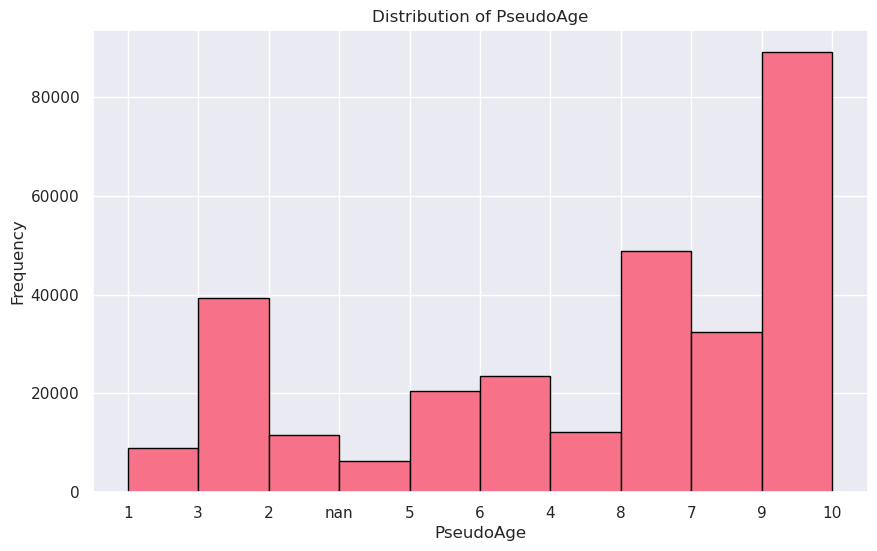

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(data_df.PseudoAge_Binned.astype(str), bins=10, edgecolor='black')
plt.xlabel('PseudoAge')
plt.ylabel('Frequency')
plt.title('Distribution of PseudoAge')
plt.show()

# Data subsets

In [19]:
type(data_df.Subclass)

pandas.core.series.Series

In [20]:
data_df_forebrain_dorsal = data_df[data_df.Tissue == 'ForebrainDorsal']
print(data_df_forebrain_dorsal.shape)

(49370, 13)


In [21]:
print(list(data_df_forebrain_dorsal.Subclass.unique()))

print(list(data_df_forebrain_dorsal.Class.unique()))

['Epiblast', 'Fourth-ventricle roof plate', 'Mesenchyme', 'Undefined', 'Caudal', 'Optic cup', 'Neural crest', 'Surface ectoderm', 'Lateral nasal pit', 'Olfactory pit', 'Olfactory epithelium', 'Erythrocyte', 'Erythroid progenitor', 'Chondrocytes', 'Early fibroblasts', 'Perivascular fibroblast-like cells', 'Pia 1', 'Pia 2', 'Pia 3', 'Intermediate meninges 1', 'Dura', 'Intermediate meninges 2', 'Arachnoid', 'Pericyte', 'Vascular smooth muscle', 'Endothelial', 'Angioblast', 'Axon tract-associated microglia', 'Cycling microglia', 'Non-cycling microglia', 'Non-cycling perivascular macrophages', 'Cycling perivascular macrophages', 'Early macrophage', 'Infiltrating immune', 'Platelet', 'Forebrain astrocyte', 'Forebrain', 'Dorsal forebrain', 'Cortical hem', 'Midbrain-hindbrain boundary', 'Ventral midbrain', 'Dorsal midbrain', 'Hypothalamic floor-plate like', 'Roof plate', 'Anteromedial cerebral pole', 'Dorsal diencephalon', 'Mixed region', 'Midbrain', 'Choroid plexus', 'Spinal cord', 'Hypothala

In [22]:
data_df_forebrain_dorsal[data_df_forebrain_dorsal.Class.isin(['Gastrulation', 'Neural tube', 'Neural crest', 'Neuroblast', 'Neuron'])]['Class'].value_counts()

Class
Neuron          22960
Neuroblast      11761
Neural tube         3
Gastrulation        1
Neural crest        1
Name: count, dtype: int64

In [23]:
data_df_forebrain_dorsal_neurons = data_df_forebrain_dorsal[data_df_forebrain_dorsal.Class.isin(['Neuron'])]

# Plots

## Cell type expression

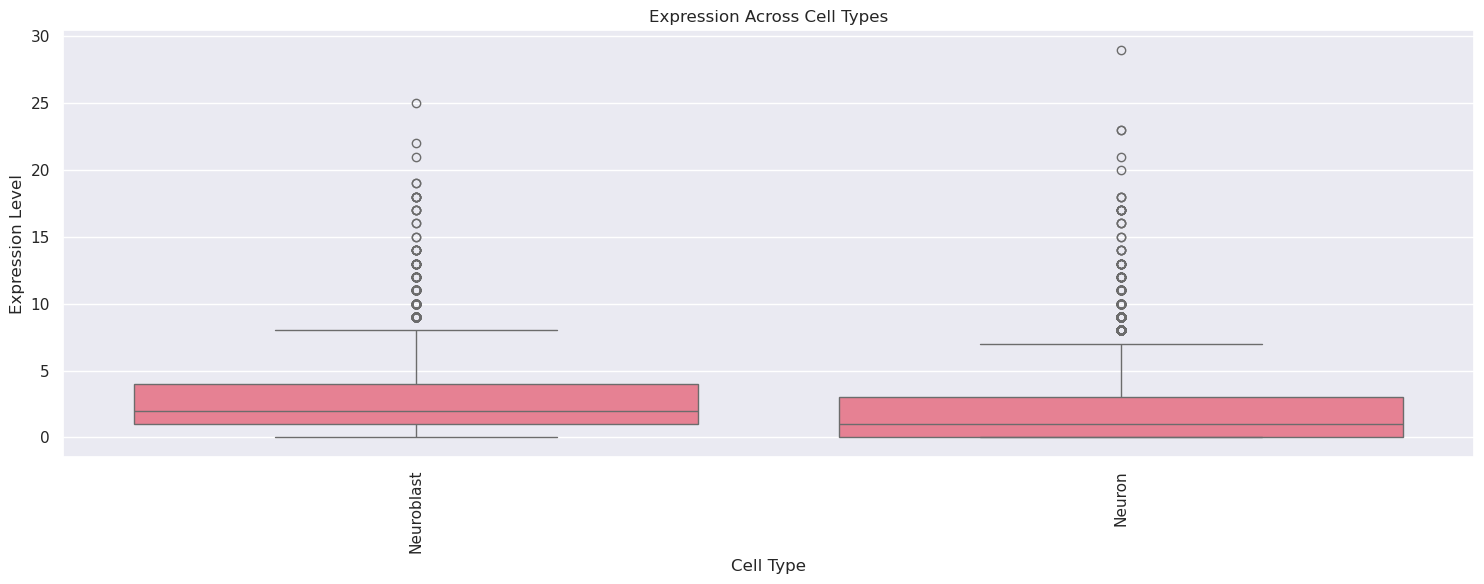

In [24]:
plot_cell_type_expression(data_df_forebrain_dorsal[data_df_forebrain_dorsal.Class.isin(['Neuroblast', 'Neuron'])])  

In [25]:
pseudo_cells_by_class = create_pseudo_cells(data_df_forebrain_dorsal[data_df_forebrain_dorsal.Class.isin(['Neuroblast', 'Neuron'])], 'Class')
pseudo_cells_by_class.head()

,Class,PseudoAge,Expression,TotalUMI,NGenes,CellCount,Tissue,Sex,Subclass,Region,Age
0,Neuroblast,14.44,2.60,4598.79,2163.60,11761,ForebrainDorsal,?,Neuronal intermediate progenitor,Forebrain,e15.0
1,Neuron,15.57,1.89,4964.57,2271.88,22960,ForebrainDorsal,?,Cortical or hippocampal glutamatergic,Forebrain,e15.0


## Temporal expression

In [26]:
print("Age value counts:")
print(data_df_forebrain_dorsal_neurons.Age.value_counts())
print("\nPseudoAge_Binned value counts:")
print(data_df_forebrain_dorsal_neurons.PseudoAge_Binned.value_counts())

Age value counts:
Age
e15.0     4968
e18.0     3412
e17.0     2376
e16.5     2319
e14.5     2031
e17.5     1893
e15.5     1667
e12.0     1400
e16.25    1282
e13.5     1092
e12.5      520
Name: count, dtype: int64

PseudoAge_Binned value counts:
PseudoAge_Binned
9     7882
8     7394
10    3874
7     2950
6      756
5      101
4        2
1        0
2        0
3        0
Name: count, dtype: int64


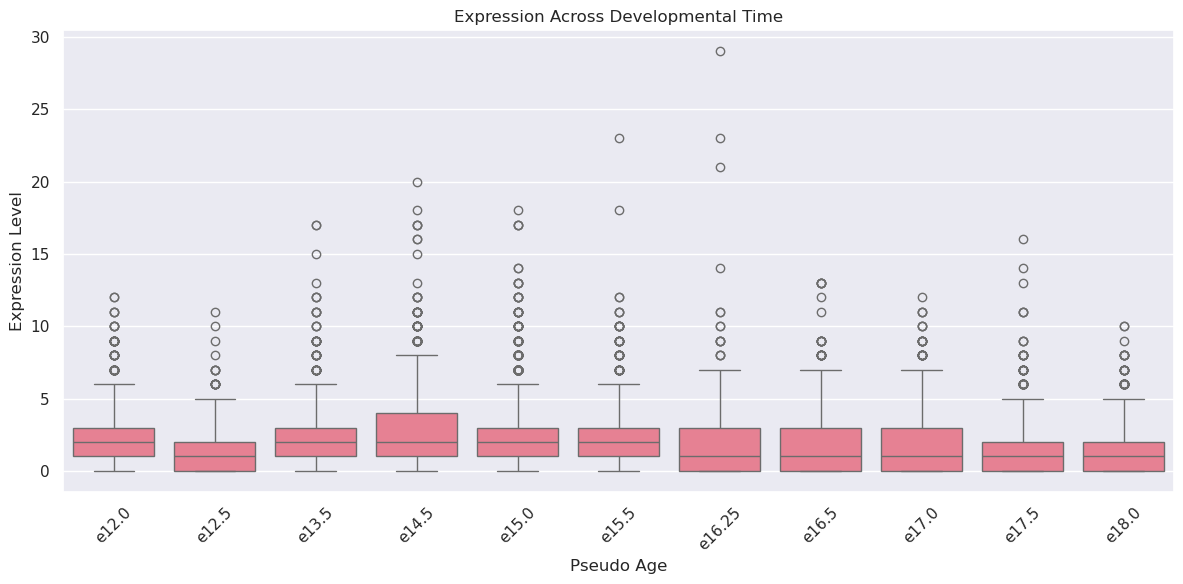

In [27]:
plot_temporal_expression(data_df_forebrain_dorsal_neurons, "Age")

In [28]:
pseudo_cells_by_age = create_pseudo_cells(data_df_forebrain_dorsal_neurons, 'Age')
pseudo_cells_by_age.head()

,Age,PseudoAge,Expression,TotalUMI,NGenes,CellCount,Tissue,Sex,Subclass,Region,Class
0,e12.0,13.69,2.11,5220.85,2433.02,1400,ForebrainDorsal,?,Forebrain glutamatergic,Forebrain,Neuron
1,e12.5,14.23,1.39,4985.39,2300.87,520,ForebrainDorsal,?,Forebrain glutamatergic,Forebrain,Neuron
2,e13.5,14.73,2.31,5978.14,2485.26,1092,ForebrainDorsal,?,Cortical or hippocampal glutamatergic,Forebrain,Neuron
3,e14.5,14.91,2.69,6271.51,2593.34,2031,ForebrainDorsal,?,Cortical or hippocampal glutamatergic,Forebrain,Neuron
4,e15.0,15.14,2.05,4930.10,2276.01,4968,ForebrainDorsal,?,Cortical or hippocampal glutamatergic,Forebrain,Neuron


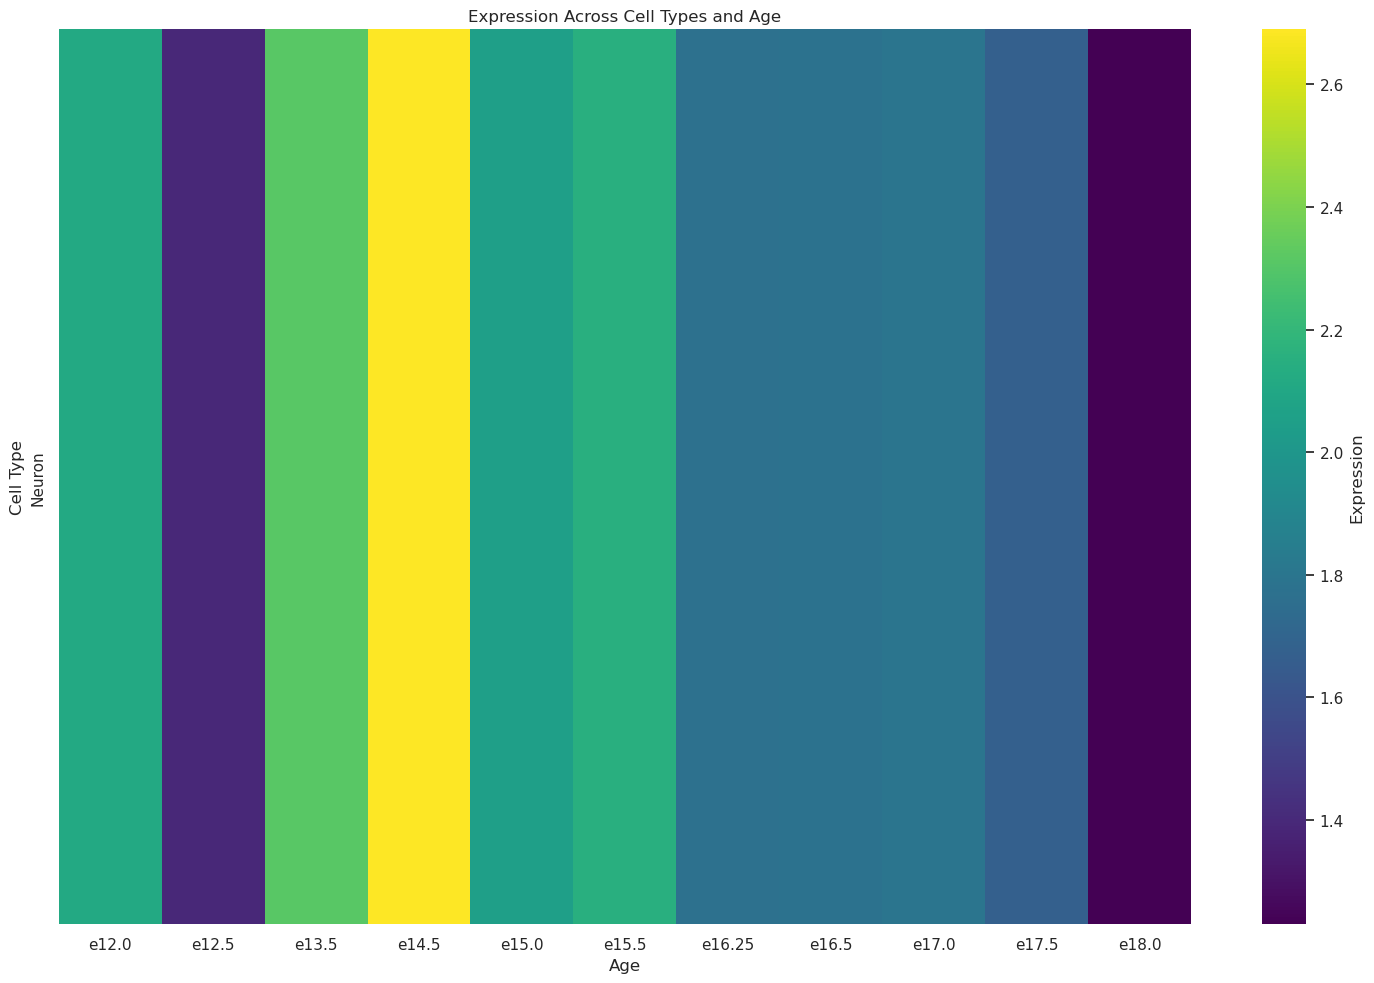

In [29]:
plot_temporal_cell_type_heatmap(pseudo_cells_by_age,"Age")

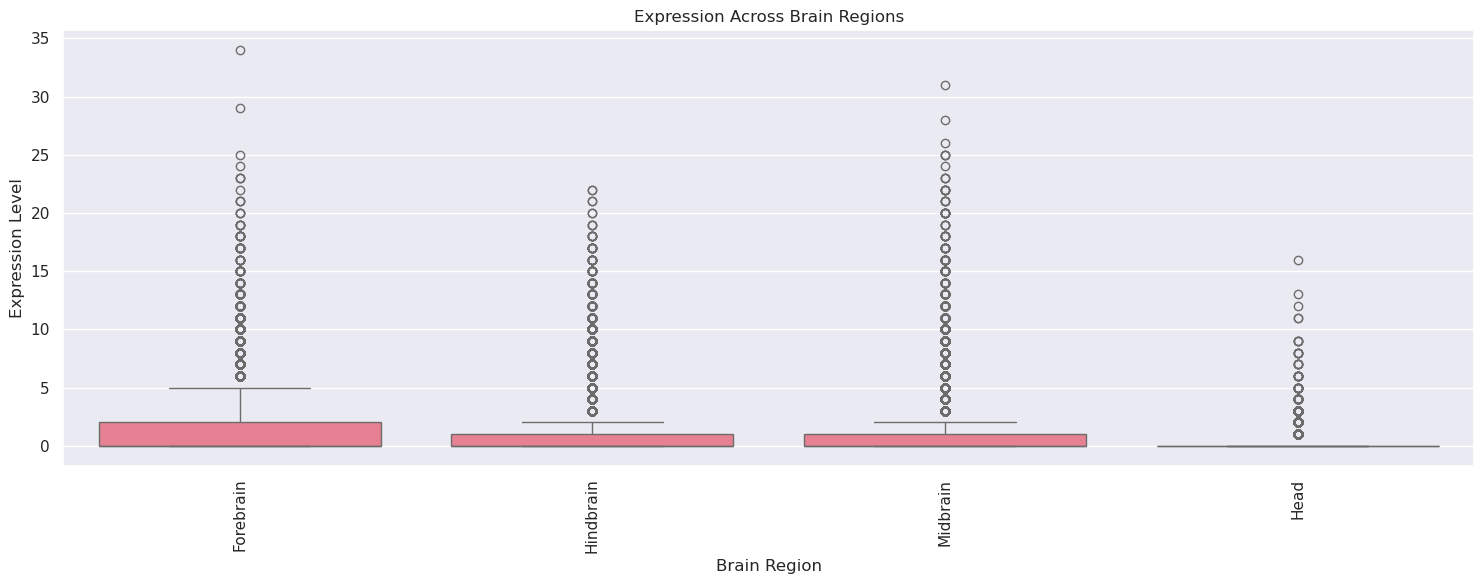

In [30]:
plot_regional_expression(data_df)

In [31]:
pseudo_cells_by_region = create_pseudo_cells(data_df, 'Region')
pseudo_cells_by_region.head()

,Region,PseudoAge,Expression,TotalUMI,NGenes,CellCount,Tissue,Sex,Subclass,Age,Class
0,Forebrain,14.19,1.05,5929.33,2351.23,138419,ForebrainDorsal,?,Cortical or hippocampal glutamatergic,e12.0,Neuron
1,Head,7.69,0.10,11979.60,3177.01,24026,All (No extraembryonal),?,Epiblast,e7.0,Gastrulation
2,Hindbrain,13.63,0.85,7272.81,2551.46,70781,Hindbrain,?,Hindbrain,e10.0,Neuron
3,Midbrain,13.43,0.83,7209.30,2586.79,59269,Midbrain,?,Midbrain glutamatergic,e10.0,Neuron


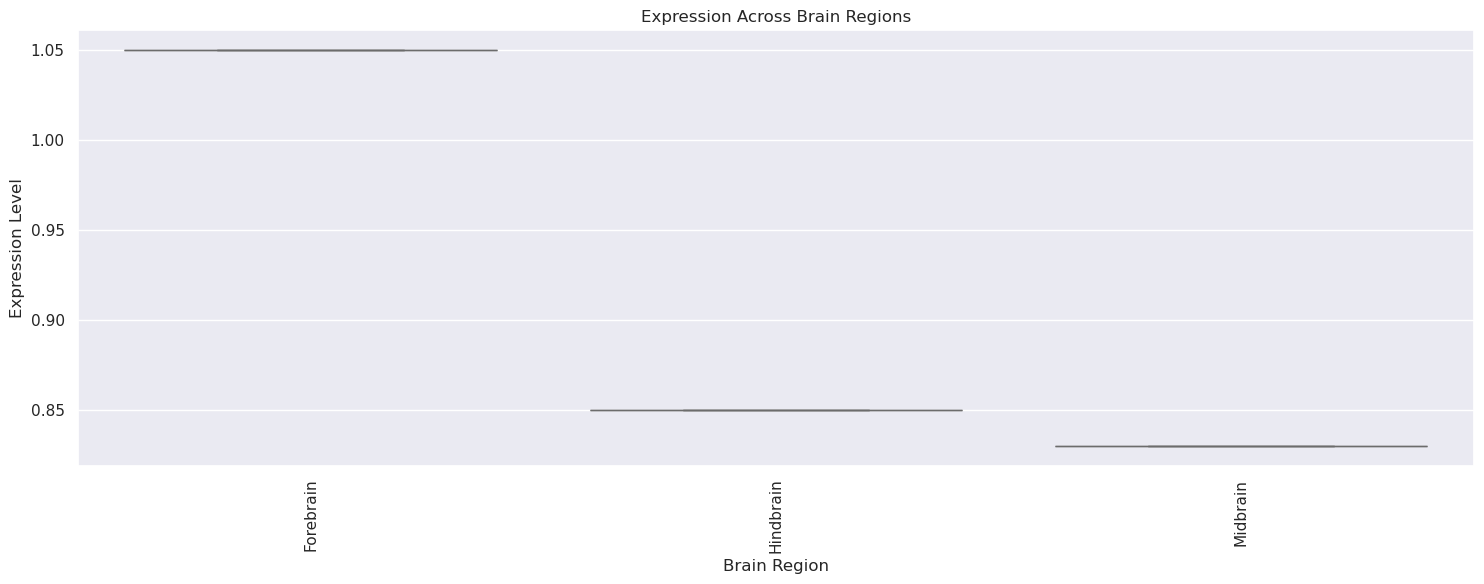

In [32]:
plot_regional_expression(pseudo_cells_by_region[pseudo_cells_by_region.Class.isin(['Neuron'])])

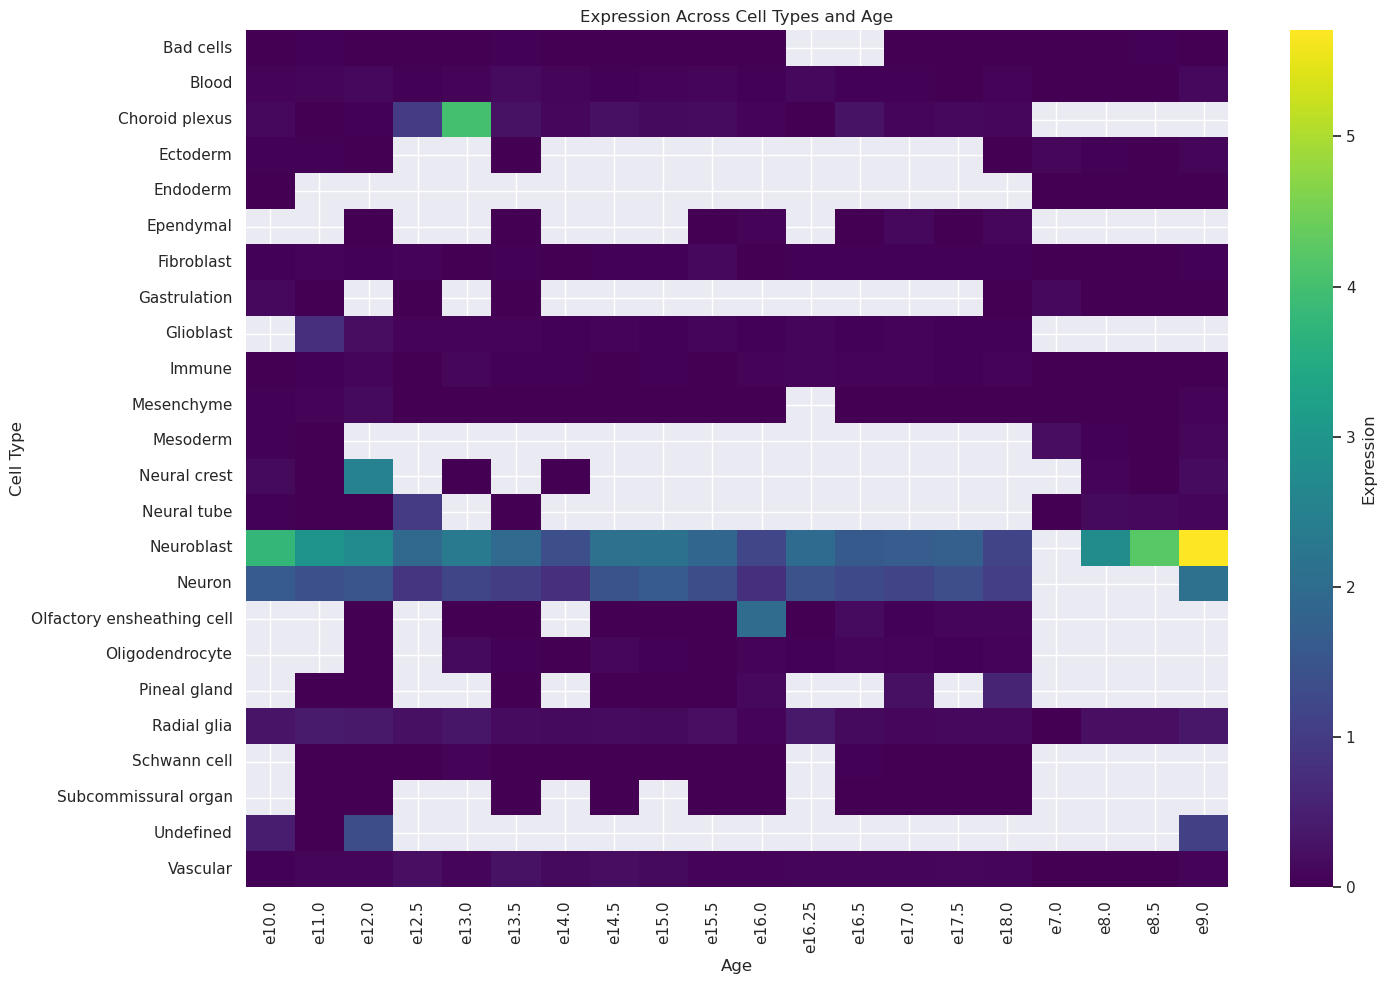

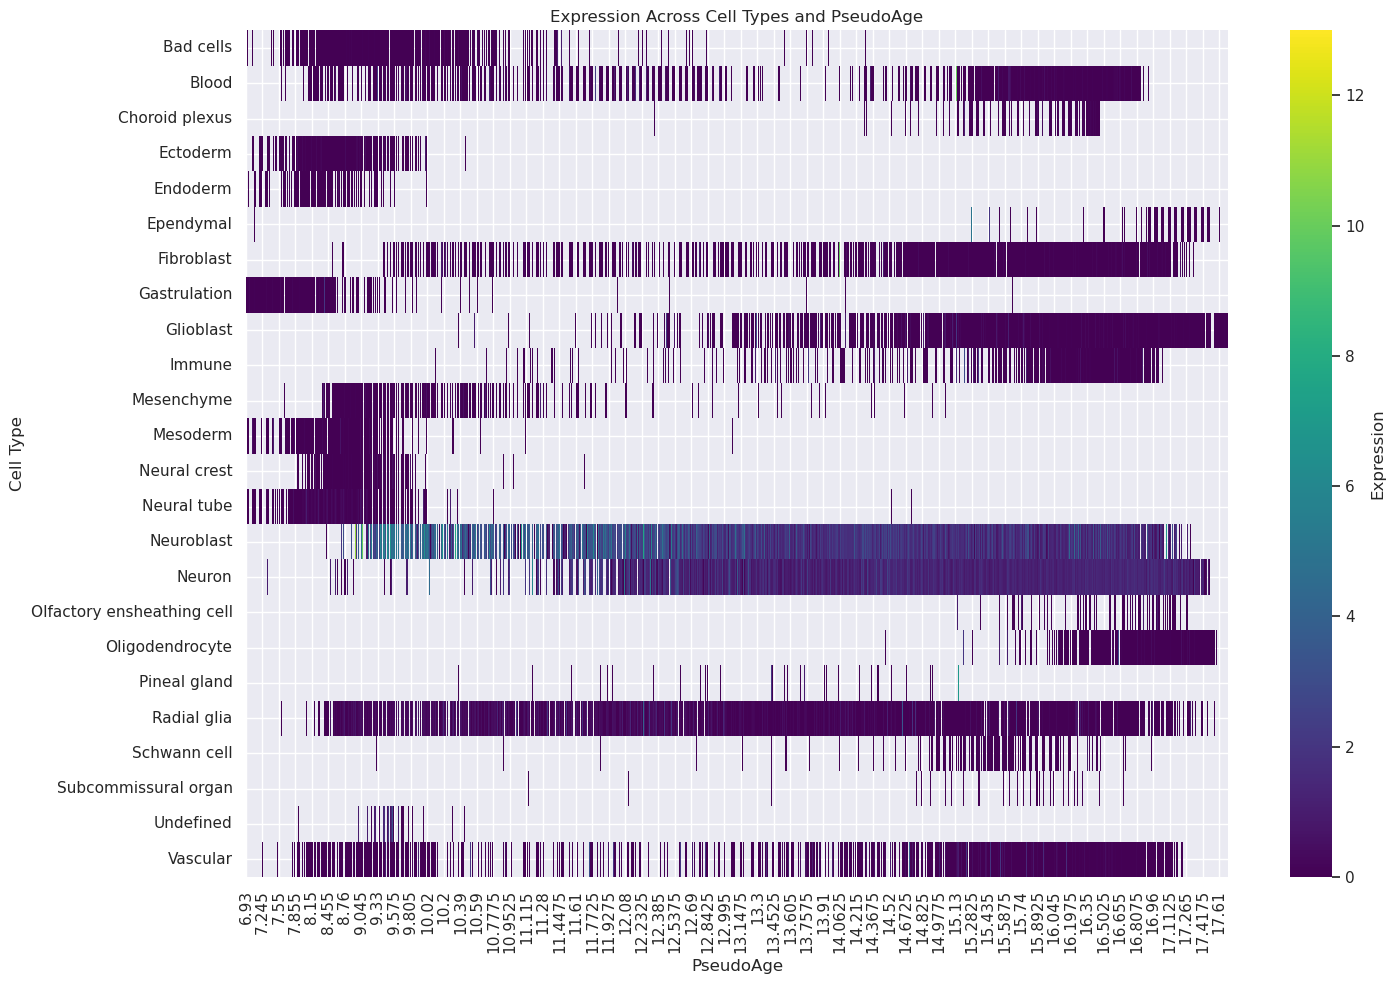

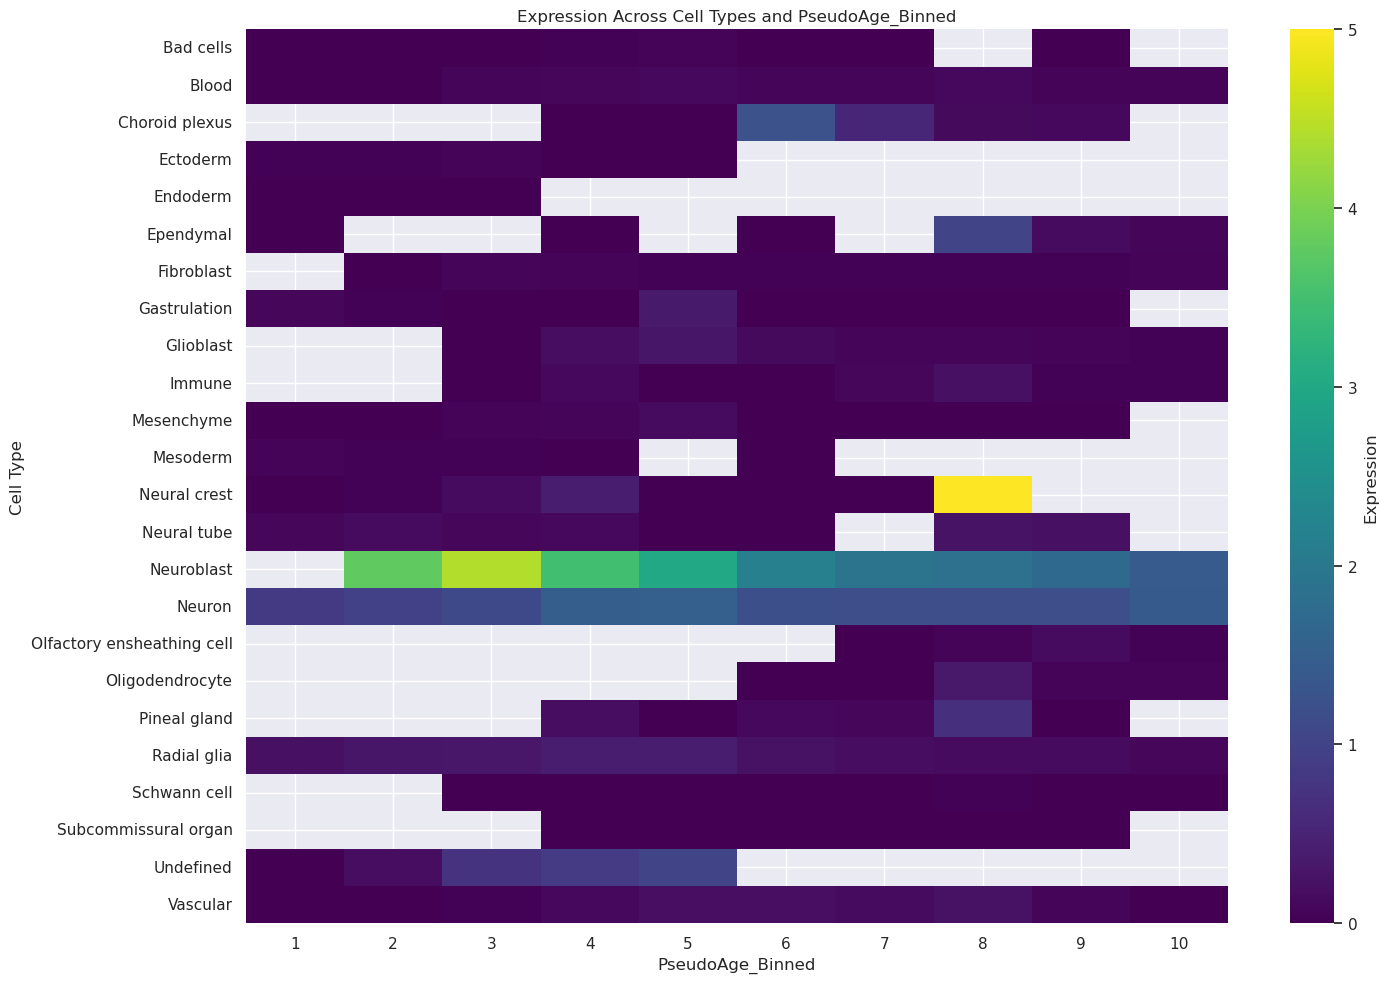

In [33]:
plot_temporal_cell_type_heatmap(data_df, "Age")
plot_temporal_cell_type_heatmap(data_df, "PseudoAge")
plot_temporal_cell_type_heatmap(data_df, "PseudoAge_Binned")

# Statistics

In [34]:
# Basic statistics
print("\nSrrm4 Expression Statistics:")
print(f"Mean expression: {np.mean(data['Expression']):.4f}")
print(f"Median expression: {np.median(data['Expression']):.4f}")
print(f"Percentage of cells expressing Srrm4: {(data['Expression'] > 0).mean() * 100:.2f}%")


Srrm4 Expression Statistics:
Mean expression: 0.8786
Median expression: 0.0000
Percentage of cells expressing Srrm4: 36.21%


In [35]:
# Top expressing cell types
df = pd.DataFrame({
    'Cell Type': data['Class'],
    'Expression': data['Expression']
})

print("\nTop 5 Cell Types by Mean Srrm4 Expression:")
print(df.groupby('Cell Type')['Expression']
        .agg(['mean', 'count'])
        .sort_values('mean', ascending=False)
        .head())


Top 5 Cell Types by Mean Srrm4 Expression:
                  mean   count
Cell Type                     
Neuroblast    2.319647   45178
Neuron        1.209863  111063
Undefined     0.704142     169
Radial glia   0.296685   40629
Pineal gland  0.205607     107
